<a href="https://colab.research.google.com/github/ryandhikafm/DTI-Telkom/blob/Text-Mining/Hate_Speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tweet Hate Speech

## Import Library

In [1]:
pip install Sastrawi

In [2]:
pip install nltk

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import nltk
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn import preprocessing
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

#Tokenize
from nltk.tokenize import TweetTokenizer
import warnings

warnings.filterwarnings('ignore')

In [20]:
nltk.download('stopwords')

stopwords_indonesia = stopwords.words("indonesian")
factory = StemmerFactory()
stemmer = factory.create_stemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Read Data

In [6]:
df = pd.read_csv('dataset.txt', sep='\t', header=None, names=['label', 'tweet'], skiprows=1, engine='python')
df.head()

,label,tweet
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi...
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan...
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja..."
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal P...


In [7]:
df.shape

(713, 2)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713 entries, 0 to 712
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   713 non-null    object
 1   tweet   713 non-null    object
dtypes: object(2)
memory usage: 11.3+ KB


## Data Preprocessing

In [9]:
encode = preprocessing.LabelEncoder()
df['label'] = encode.fit_transform(df['label'])

In [10]:
df.head()

,label,tweet
0,1,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...
1,1,RT @baguscondromowo: Mereka terus melukai aksi...
2,1,Sylvi: bagaimana gurbernur melakukan kekerasan...
3,1,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja..."
4,1,RT @lisdaulay28: Waspada KTP palsu.....kawal P...


In [11]:
def tokenize(s, remove_punctuation=True):
    if remove_punctuation == True:
        tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
        clean_words = tokenizer.tokenize(s)
    else:
        clean_words = nltk.word_tokenize(s)
    return clean_words

# Tokenize words
df['tweet'] = df['tweet'].apply(tokenize)

In [12]:
df.head()

,label,tweet
0,1,"[RT, @spardaxyz:, Fadli, Zon, Minta, Mendagri,..."
1,1,"[RT, @baguscondromowo:, Mereka, terus, melukai..."
2,1,"[Sylvi, :, bagaimana, gurbernur, melakukan, ke..."
3,1,"[Ahmad, Dhani, Tak, Puas, Debat, Pilkada, ,, M..."
4,1,"[RT, @lisdaulay28:, Waspada, KTP, palsu, ........"


In [17]:
def tweet_clean(tokens):
    new_tweet = []
    for tweet in tokens:
            #remove number
            tweet = re.sub('[0-9]+', '', tweet)
            tweet = re.sub(r'\$\w*', '', tweet)

            #remove hashtag
            tweet = re.sub(r'#', '', tweet)
           
            # Remove mention
            tweet = re.sub('@[^\s]+', '', tweet)

            # Remove urls
            tweet = re.sub(r'\\/', '', tweet) 
            tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet) 

            # Remove special character 
            tweet = re.sub('[^a-zA-Z\s]', '', tweet)

            new_tweet.append(tweet)

    return [token for token in new_tweet if token]

df['tweet'] = df['tweet'].apply(tweet_clean)

In [19]:
df.head()

,label,tweet
0,1,"[RT, Fadli, Zon, Minta, Mendagri, Segera, Meno..."
1,1,"[RT, Mereka, terus, melukai, aksi, dalam, rang..."
2,1,"[Sylvi, bagaimana, gurbernur, melakukan, keker..."
3,1,"[Ahmad, Dhani, Tak, Puas, Debat, Pilkada, Masa..."
4,1,"[RT, Waspada, KTP, palsu, kawal, PILKADA, http..."


In [23]:
def stemming(tokens):
    
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    return [stemmer.stem(tweet) for tweet in tokens]

df['tweet'] = df['tweet'].apply(stemming)

In [24]:
df.head()

,label,tweet
0,1,"[rt, fadli, zon, minta, mendagri, segera, nona..."
1,1,"[rt, mereka, terus, luka, aksi, dalam, rangka,..."
2,1,"[sylvi, bagaimana, gurbernur, laku, keras, per..."
3,1,"[ahmad, dhani, tak, puas, debat, pilkada, masa..."
4,1,"[rt, waspada, ktp, palsu, kawal, pilkada, http..."


In [31]:
df['tweet'] = df['tweet'].apply(lambda x: ' '.join(x))

In [32]:
df.head()

,label,tweet
0,1,rt fadli zon minta mendagri segera nonaktif ah...
1,1,rt mereka terus luka aksi dalam rangka penjara...
2,1,sylvi bagaimana gurbernur laku keras perempuan...
3,1,ahmad dhani tak puas debat pilkada masalah jal...
4,1,rt waspada ktp palsu kawal pilkada https tcooo...


## Feature Extraction

In [33]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3), min_df=2, max_features=10000)

# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(df['tweet'] )
tfidf

<713x1999 sparse matrix of type '<class 'numpy.float64'>'
	with 10681 stored elements in Compressed Sparse Row format>

## Modeling

In [34]:
X = tfidf
y = df['label'].astype(int)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X.toarray(), y, test_size=0.2, random_state=42, )

In [41]:
print(X_train.shape)
print(X_test.shape)

(570, 1999)
(143, 1999)


In [43]:
# Modeling Random Forest Classifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Predict to Test Data
y_pred_rf= rf.predict(X_test)

In [44]:
cm_rf = metrics.confusion_matrix(y_test, y_pred_rf)
cm_rf

array([[33, 12],
       [ 7, 91]])

In [45]:
acc_rf = metrics.accuracy_score(y_test, y_pred_rf)
prec_rf = metrics.precision_score(y_test, y_pred_rf)
rec_rf = metrics.recall_score(y_test, y_pred_rf)
f1_rf = metrics.f1_score(y_test, y_pred_rf)
kappa_rf = metrics.cohen_kappa_score(y_test, y_pred_rf)

print("Accuracy:", acc_rf)
print("Precision:", prec_rf)
print("Recall:", rec_rf)
print("F1 Score:", f1_rf)
print("Cohens Kappa Score:", kappa_rf)

Accuracy: 0.8671328671328671
Precision: 0.883495145631068
Recall: 0.9285714285714286
F1 Score: 0.9054726368159205
Cohens Kappa Score: 0.6824079485680888


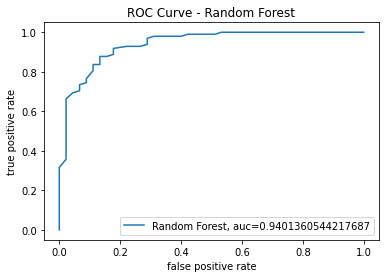

In [47]:
# ROC Curve
y_pred_rf_proba = rf.predict_proba(X_test)[::,1]
fprrf, tprrf, _ = metrics.roc_curve(y_test,  y_pred_rf_proba)
aucrf = metrics.roc_auc_score(y_test, y_pred_rf_proba)
plt.plot(fprrf,tprrf,label="Random Forest, auc="+str(aucrf))
plt.title('ROC Curve - Random Forest')
plt.xlabel('false positive rate') 
plt.ylabel('true positive rate')
plt.legend(loc=4)
plt.show()